<a href="https://colab.research.google.com/github/KKottmann/simple-DMRG-with-MPS/blob/master/DMRG_Transverse_Ising_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Linear Algebra
import numpy as np
from scipy.linalg import svd
from numpy.linalg import qr
import scipy.sparse.linalg.eigen.arpack as arp

# Python Plotting
from matplotlib import pyplot as plt

# Own modules
from DMRG import * # here is the main part of the DMRG code

# we'll need them a lot
sxx = np.array([[0., 1.], [1., 0.]])
syy = np.array([[0., -1j], [1j, 0.]])
szz = np.array([[1., 0.], [0., -1.]])

# DMRG on the transverse nearest neighbor Ising model

I implement the density matrix renormalization group algorithm (DMRG) for matrix product states (MPS).  
Exemplarly I use the transverse nearest neighbor Ising model  
$$
H = - J \sum_{i=0}^{L-2} \sigma^x_i \sigma^x_{i+1} - g \sum_{i=0}^{L-1} \sigma^z_i
$$
We compare for small number of sites $L<20$ to exact diagonalization of the Hamiltonian

## MPS
First we need to define an MPS class and initialize a random MPS
This function is defined in <DMRG.py> and looks something like this  

In [0]:
help(random_MPS)

Help on class random_MPS in module DMRG:

class random_MPS(builtins.object)
 |  random_MPS(L, d, chi_max)
 |  
 |  Initializes a random, finite dimensional, unnormalized MPS
 |  
 |  
 |  Parameters
 |  ------------
 |  L: Number of Sites
 |  d: local Hilbert space dimension (Schollwöck: sigma_j = 1,..,d)
 |  chi: local bond dimension (Schollwöch: DxD matrices)
 |  
 |  attributes:
 |  Ms: list of L ndim=3 tensors M with indices Ms[j]: sigma_j, vL, vR
 |  Ss: list of L ndim=1 lists with the Schmidt values
 |  L: number of sites
 |  chi: list of bond dimensions, -chi(i-1)--Ms[i]--chi(i)--Ms[i+1]--..
 |  normstat = None, 'left-norm', 'right-norm'
 |  
 |  Methods defined here:
 |  
 |  __init__(self, L, d, chi_max)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_Mi(self, i)
 |  
 |  left_normalize(self, test=False)
 |      returns a left_normalized version of the random_MPS() object using QR
 |  
 |  right_normalize(self, test=False)
 |      returns a 

The MPS basically consist of the list Ms that containts the ndim=3 arrays at each site. The legs are ordered $a_{i-1}, s_i, a_i$ (virtual left, physical, virtual right)  
Sites are labeled from $0$ to $L-1$  

In [0]:
randmps = random_MPS(L=10,d=3,chi_max=5)
[randmps.Ms[i].shape for i in range(10)]

[(1, 3, 3),
 (3, 3, 5),
 (5, 3, 5),
 (5, 3, 5),
 (5, 3, 5),
 (5, 3, 5),
 (5, 3, 5),
 (5, 3, 5),
 (5, 3, 3),
 (3, 3, 1)]

In [0]:
randmps = random_MPS(L=10,d=3,chi_max=500)
[randmps.Ms[i].shape for i in range(10)]

[(1, 3, 3),
 (3, 3, 9),
 (9, 3, 27),
 (27, 3, 81),
 (81, 3, 243),
 (243, 3, 81),
 (81, 3, 27),
 (27, 3, 9),
 (9, 3, 3),
 (3, 3, 1)]

## MPO
The MPO basically consists of the list Ws that contains the ndim=4 arrays at each site.  
The indices are set as $b_{i-1}, b_i, \sigma_i, \sigma'_i$  
For the transverse Ising model the matrices read
$$
W_{b_{i-1} b_i} = \begin{pmatrix}
\mathbb{I} & \sigma^x & - g \sigma^z \\
0 & 0 & - J \sigma^x \\
0 & 0 & \mathbb{I} \\
\end{pmatrix}
$$
The left row vector is the top row and the right column vector is the right column.

In [0]:
help(Ising_MPO)

Help on class Ising_MPO in module DMRG:

class Ising_MPO(builtins.object)
 |  Ising_MPO(L, d, h, J)
 |  
 |  Transverse Ising field Hamiltonian
 |  H = -J \sum_i \sigma_i^x \sigma_{i+1}^x - h \sum_i \sigma_i^z
 |  
 |  Methods defined here:
 |  
 |  __init__(self, L, d, h, J)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  init_W(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [0]:
isingmpo = Ising_MPO(L=10,d=2,h=0.5,J=1.0)
[isingmpo.Ws[i].shape for i in range(10)]

[(1, 3, 2, 2),
 (3, 3, 2, 2),
 (3, 3, 2, 2),
 (3, 3, 2, 2),
 (3, 3, 2, 2),
 (3, 3, 2, 2),
 (3, 3, 2, 2),
 (3, 3, 2, 2),
 (3, 3, 2, 2),
 (3, 1, 2, 2)]

## DMRG
Now I create an abstract class that acts as my DMRG engine and takes care of all the quantities needed for the algorithm, i.e. the MPS, the LP and the RP

In [0]:
help(DMRG)

Help on class DMRG in module DMRG:

class DMRG(builtins.object)
 |  DMRG(MPS, MPO, eps=1e-10, chi_max=None, test=False)
 |  
 |  Abstract DMRG engine class
 |  
 |  attributes:
 |  MPS*: the current MPS
 |  MPO: the model MPO
 |  RPs*: the current RPs
 |  LPs*: the current LPs
 |  (*): get regular updates
 |  
 |  LPs[i] is LP left site i, i.e. LPs[0] is dummy and LPs[-1] = LPs[L-1] is everything but the last
 |  RPs[i] is RP right of site i, i.e. RPs[-1]=RPs[L-1] is dummy and RPs[0] is everything but the first
 |  
 |  Parameters:
 |  MPS: object, matrix product state
 |  MPO: object, matrix product operator
 |  eps: float, epsilon determining the threshold of which singular values to keep, standard set to 10^-10
 |  chi_max: int, maximal bond dimension of system
 |  test: for debugging, prints things like Ms.shape, norm, singular values etc. during sweep
 |  
 |  Methods defined here:
 |  
 |  __init__(self, MPS, MPO, eps=1e-10, chi_max=None, test=False)
 |      Initialize self.  See

In [0]:
init_mps = random_MPS(L=10,d=2,chi_max=1000)
mpo = Ising_MPO(L=10,d=2,h=0.7,J=0.3)
dmrg = DMRG(init_mps,mpo,eps=-1.,chi_max=1000,test=False)

A full sweep is performed by going left-to-right and then right-to-left again  
The engine initially right-normalizes the state  
(also note that the dmrg engine is manipulating the mps instance itself!)

In [0]:
init_mps = random_MPS(L=10,d=2,chi_max=1000)
print(init_mps.normstat)

None


In [0]:
dmrg = DMRG(init_mps,mpo,eps=-1.,chi_max=1000,test=False)

In [0]:
print(init_mps.normstat)

right-norm


After a left-to-right (l2r) sweep all matrices become left-normalized, the engine fixes the status after l2r

In [0]:
dmrg.left_to_right()
print(init_mps.normstat)

left-norm


(actually before doing a l2r or r2l sweep the engine checks the *normstat* of the MPS, pretty clever huh)

In [0]:
dmrg.left_to_right()

AssertionError: 

In [0]:
dmrg.right_to_left()

Some important subtleties:  
LPs and RPs have length L while LPs[0] = RPs[-1] = ones(1,1,1) is the dummy. Therefore neither contains the full contraction at any time and LP[i] and RP[i] are EXCLUDING site i!

In [0]:
print([dmrg.LPs[i].shape for i in range(10)])
print([dmrg.RPs[i].shape for i in range(10)])

[(1, 1, 1), (2, 3, 2), (4, 3, 4), (8, 3, 8), (16, 3, 16), (32, 3, 32), (16, 3, 16), (8, 3, 8), (4, 3, 4), (2, 3, 2)]
[(2, 3, 2), (4, 3, 4), (8, 3, 8), (16, 3, 16), (32, 3, 32), (16, 3, 16), (8, 3, 8), (4, 3, 4), (2, 3, 2), (1, 1, 1)]


### Eigenenergies
At each step in l2r or r2l the engine calculates a new, better matrix and then right- or left-normalizes it.  
The *better* matrix is obtained from solving the Eigenvalue problem of the effective Hamiltonian at site i  
$$
\sum_{\sigma'_l,a'_{l-1},a'_l} \left(H_\text{eff}\right)^{\sigma_l \sigma'_l}_{a_{l-1} a'_{l-1} a_l a'_l} M^{\sigma'_l}_{a'_{l-1},a'_l} = \lambda M^{\sigma_l}_{a_{l-1},a_l}
$$
where
$$
\left(H_\text{eff}\right)^{\sigma_l \sigma'_l}_{a_{l-1} a'_{l-1} a_l a'_l} = \sum_{b_{l-1},b_l} L^{a_{l-1} a'_{l-1}}_{b_{l-1}} W^{\sigma_l \sigma'_l}_{b_{l-1} b_l} R^{a_l a'_l}_{b_l}
$$

which graphically is represented by  
![visualization of eigenproblem](img/eigenproblem.png)  
(see Schollwöck chap 6)  
We are solving for the circled matrix M  
The Eigenvalue $\lambda$ on the other hand corresponds to the curent ground state energy and is saved (appended to) into ```dmrg.e```

In [0]:
step_es = np.array(dmrg.e)

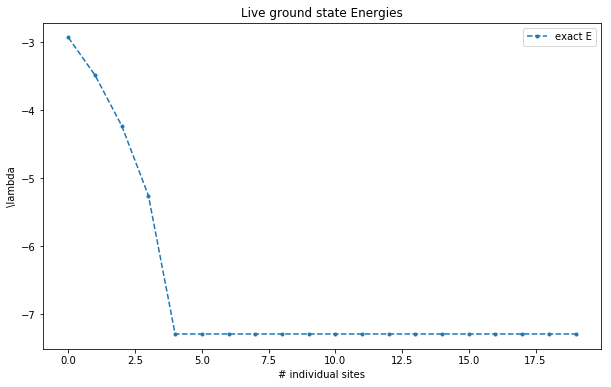

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,6))

ax=axes
ax.plot(step_es,'.--',label='exact E')
ax.set(xlabel='# individual sites', ylabel='\\lambda',
       title='Live ground state Energies')
ax.legend()

## Exact Diagonalization
This part is copy-paste from TeNPy toycodes (https://github.com/tenpy/tenpy) and provides the exact diagonalization of the same transverse Ising Hamiltonian

In [0]:
"""Provides exact ground state energies for the transverse field ising model for comparison.

The Hamiltonian reads
.. math ::
    H = - J \\sum_{i} \\sigma^x_i \\sigma^x_{i+1} - g \\sum_{i} \\sigma^z_i
"""
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate


def exact_E(L, J, g):
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_xx = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_xx = H_xx + sx_list[i] * sx_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
    H = -J * H_xx - g * H_z
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return E[0]

## Plotting
Now we compare the results and see that they match perfectly  
We write a brute force function that calculates the GS energy via DMRG within some confidence (to know when it is *close enough* to the GS energy. Here in this example one full sweep is already enough usually (put test=True to see how many sweeps it needs each time)

In [0]:
def dmrg_E(L,J,g,conf=1e-4,test=False):
    # Initialize random MPS and MPO
    init_mps = random_MPS(L=L,d=2,chi_max=100)
    mpo = Ising_MPO(L=L,d=2,h=g,J=J)
    dmrg = DMRG(init_mps,mpo,eps=-1.,chi_max=100,test=False)
    
    diff = 5.*conf
    counter = 0
    while diff > conf:
        if test:
            print(counter)
        counter += 1
        ### note: we could also simply use the current dmrg.e value to speed things up. This is just to give justification to the expect_mpo(mps,mpo) function
        e_in = expect_mpo(dmrg.MPS,mpo)
        dmrg.left_to_right()
        dmrg.right_to_left()
        e_end = expect_mpo(dmrg.MPS,mpo)
        diff = abs(e_in - e_end)
        if counter > 50:
            break
    return dmrg.e[-1]

In [0]:
gs = np.linspace(0.,2.,20)
dmrg_Es = np.array([dmrg_E(L=10,g=g,J=1.) for g in gs])
exact_Es = np.array([exact_E(L=10,g=g,J=1.) for g in gs])

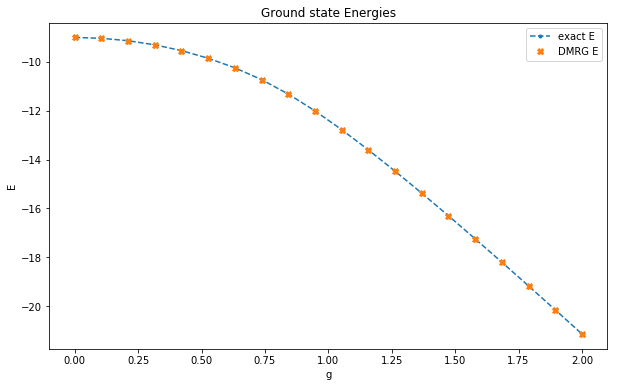

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,6))

ax=axes
ax.plot(gs,exact_Es,'.--',label='exact E')
ax.plot(gs,dmrg_Es,'X',label='DMRG E')
ax.set(xlabel='g', ylabel='E',
       title='Ground state Energies')
ax.legend()

We see that the results match perfectly so I assume the algorithm is working (in principle at least)